In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile 
zip_ref=zipfile.ZipFile("/content/drive/My Drive/intel-image-classification.zip",'r')
zip_ref.extractall('/tmp')
zip_ref.close()

<table>
    <tr style="border-top: 1px solid black; border-bottom: 1px solid black">
        <td>
            <h1>Classification d'images à partir de 6 scènes du monde entier</h1>
        </td>
    </tr>
</table>


<center><i>Réalisé par : </i> Mouhamed BA</center>

<table>
    <tr style="text-align: center;vertical-align:left">
    <td style="border-top: 1px solid black; border-bottom: 1px solid black;vertical-align: middle">     
 <h1>Plan du rapport</h1>
    </td>
   </tr>
</table>
 
<table style="width: 100%">
<tr>
    <td style="width: 15%">
    </td>
    <td style="width: 70%; text-align:left">
        <a href="#1"><h1>I. Introduction</h1></a><br>
           &emsp; <a href="#presentation">I.1 Présentation du problème</a><br>
           &emsp; <a href="#preparation">I.2 Préparation et Visualisation des données</a><br><br>

<a href="#2"><h1>II. Apprentissage par rapport aux 1000 premières images </h1></a><br><br>
    &emsp; <a href="#naives">II.1 Naives Bayes</a><br>
    &emsp; <a href="#knn">II.2 K-plus proche voisins (KNN)</a><br>
    &emsp; <a href="#svm">II.3 Support Vector Machine</a><br>

<a href="#3"><h1>III. Apprentissage sur l’ensemble des Images</h1></a><br><br>
    &emsp; <a href="#rf">III.1 Random Forest</a><br><br>
    &emsp; <a href="#ann">II.2 Réseau de Neurone Artificiels ANN (KNN)</a><br>
   
<a href="#4"><h1>III. Apprentissage avec Image data générator de Keras</h1></a><br><br>
&emsp; <a href="#ann">II.2 Réseau de Neurone Convolutionnels CNN (CNN)</a><br>

<a href="#5"><h1>IV. Conclusion</h1></a><br>
    </td>
    <td style="width: 0%">
    </td>
</tr>
</table>



# <a name="1">I. Introduction</a>

### <a name="presentation"> Présentation du problème </a>
Le Projet porte sur un probleme de classification d'images issue d'un challenge sur KAGGLE: https://www.kaggle.com/puneet6060/intel-image-classification  en Janvier 2019. Mais ces données ont été initialement publiées sur https://datahack.analyticsvidhya.com par Intel  pour organiser un concours de classification d'images dont le but initial était de construire un puissant réseau de neurones qui puisse classer ces images avec plus de précision.


Notre jeu donnée porte sur des images de 150x150 pixels .Ce sont des données d'images de Scènes naturelles du monde entier. La tâche consiste à classer ces scènes réparties en 6 catégories 
- 0 Buildings
- 1 Forest
- 2 Glacier
- 3 Mountain
- 4 Sea
- 5 Street

que l'on traduit par  (0=Bâtiments, 1=forêt , 2=glacier, 3=montagene, 4=mer, 5=rue).

Le fichier contient un fichier zip qui coontient 3 dossier qui contiennent les données relatives aux jeux d'entrainement, de tests et de prévisions sont séparées dans le fichier zip. Il y a environ 14000 images dans le jeu d'entrainement, 3000 dans le jeu de Test et 7000 dans celui des prédictions

Il s'agit donc d'un probleme de Classification, tout au long du projet nous mettrons en oeuvre des méthodes de Machine learning afin de classifier nos images et tout cela en utilisant le gpu.

Nous appliquerons dans un premier temps des techniques d’apprentissage bien choisies afin de répondre au problème posé en se basant seulement sur les 1000 premières images sans se préocuper des autres, nous regardons dans chacun des cas les différents scores obtenus notemment avec la matrice de confusion .
Dans un second temps nous appliquerons des méthodes de machine learning dans  lesquels l’ensemble des images  seront intégrées à l’apprentissage.

Enfin, nous résumons les avantages et les inconvénients de chaque modèle,
nous concluons le meilleur modèle de classification des images
dans le cadre de ce projet et nous discutons des résultats
significatifs.


### <a name="preparation"> Préparation et Visualisation des données </a>

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from random import randint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import os

In [115]:
print(os.listdir('/tmp'))

['drivefs_ipc.0', 'seg_pred', 'seg_test', 'pymp-kwivhpdc', 'seg_train', 'drivefs_ipc.0_shell', 'tmphntauk1g']


In [0]:
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers 
import tensorflow.keras.activations as Activations
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils


Identification des classes 

In [0]:
class_= ['buildings','forest', 'glacier','mountain', 'sea', 'street']
class_label ={"buildings":0,"forest": 1, "glacier":2,  "mountain": 3, "sea": 4, "street": 5}
nb_classes = 6


def get_classlabel(class_code):
    labels = {0:"buildings", 1:"forest", 2:"glacier",3:"mountain", 4:"sea",5:"street"}
    
    return labels[class_code]



Chargement de nos données 

In [0]:

def load_data():
    datasets = ["/tmp/seg_train/seg_train/", "/tmp/seg_test/seg_test/"]
    data = []
    for dataset in datasets:
        directory = dataset
        Images = []
        Labels = []
        for dir_name in os.listdir(directory):
            label = class_label[dir_name]
            for file in os.listdir(directory + "/" + dir_name):
                image = cv2.imread( directory + "/" + dir_name + "/" + file)
                image = cv2.resize(image, (150,150))
                Images.append(image)
                Labels.append(label)
        Images, Labels = shuffle(Images, Labels)     
        Images = np.array(Images, dtype = 'float32') 
        Labels = np.array(Labels, dtype = 'int32')   
        
        data.append((Images, Labels))

    return data


On normalise

In [0]:
(X_train ,y_train),(X_test,y_test)= load_data()
X_train = X_train / 255.0 
X_test = X_test / 255.0

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_train

(14034, 150, 150, 3)
(14034,)
(3000, 150, 150, 3)
(3000,)


array([2, 5, 4, ..., 0, 0, 5], dtype=int32)

In [0]:
def get_predimages(directory):
    Images = []
    for image_file in os.listdir(directory): #Extracting the file name of the image from Class Label folder
        image = cv2.imread(directory+'/'+image_file) #Reading the image (OpenCV)
        image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
        Images.append(image)
    return Images


In [0]:
X_pred = get_predimages('/tmp/seg_pred/seg_pred')
X_pred = np.array(X_pred,dtype='float32') * 1.0 / 255.0
X_pred.shape



(7301, 150, 150, 3)

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14034, 150, 150, 3)
(14034,)
(3000, 150, 150, 3)
(3000,)


Proportion observée de chaque scène 

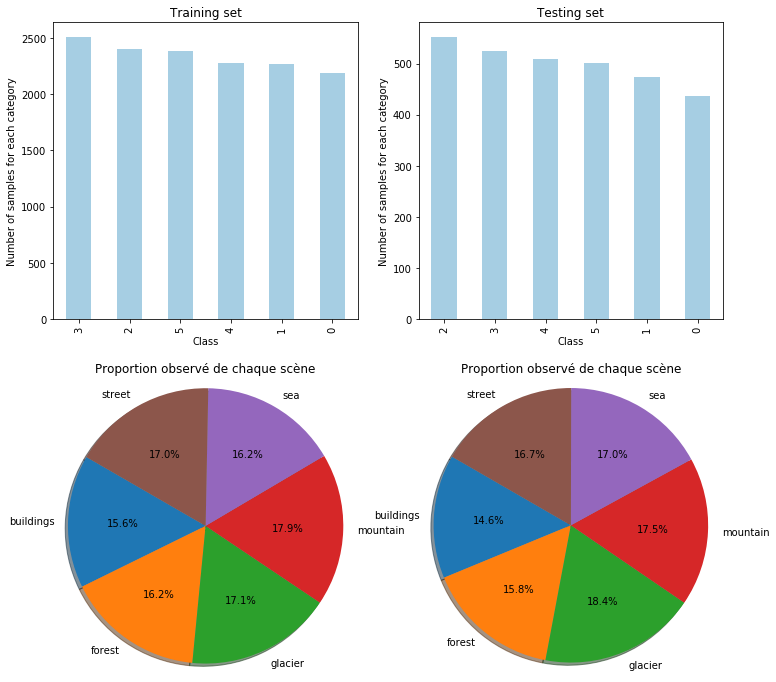

In [0]:
plt.figure(figsize=(12,12))
y_train_df = pd.DataFrame(data = y_train, columns = ['class'])
y_test_df = pd.DataFrame(data = y_test, columns = ['class'])
plt.subplot(221)
y_train_df['class'].value_counts().plot(kind = 'bar', colormap = 'Paired')
plt.xlabel('Class')
plt.ylabel('Number of samples for each category')
plt.title('Training set')
plt.subplot(222)
y_test_df['class'].value_counts().plot(kind = 'bar', colormap = 'Paired')
plt.xlabel('Class')
plt.ylabel('Number of samples for each category')
plt.title('Testing set')
plt.subplot(223)
sizes = np.bincount(y_train)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion observé de chaque scène')
plt.subplot(224)
sizes = np.bincount(y_test)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion observé de chaque scène')

plt.show()

Nous Voyons que sur les données d'entrainement la scène la plus représenté est celle des montagnes en ce qui concerne les donnée test il s'agit des glaciers dans les 2 jeux de données les batiment représente la plus faible proportion, mais on ne peut pas dire que l'écart des effectifs est énorme il varie entre 2200 et 2500 pour les donnés d'entrainement et de 420 à 550 pour les donnée de test

Matrice de confusion 

Ici nous mettons en place un programme qui renvoie la matrice de confusion de nos modèle afin d'évaluer la qualité d'une classification et nous donne un aperçu du classement de nos points.

La matrice de confusion fournit:

$\bullet$ Nombre de vrai positif (VP)

$\bullet$ Nombre de faux positif (FP)

$\bullet$ Nombre de faux négatif (FN)

$\bullet$ Nombre de vrai négatif (VN)


Et ce sont ces informations obtenues par la matrice de confusion qui nous permettent de calculer la précision et la courbe ROC.

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y, classes=None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    cm = confusion_matrix(y, y_pred)
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if classes is None:
        classes = np.unique(y)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Unnormalized confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

Courbe ROC

In [0]:
import pandas as pd
#ROC Curve
from sklearn.metrics import roc_curve, auc
def Roc_Curve(y_test,y_pred):
  a=y_test
  prediction=y_pred
  yp_dum=pd.get_dummies(a)
  yt_dum=pd.get_dummies(prediction)
  CM = confusion_matrix(a, prediction)
  class_names=np.unique(np.array(CM)) #Used for Confusion Matrix visual.
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(class_)):
    fpr[i], tpr[i], _ = roc_curve(yt_dum[i], yp_dum[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  plt.figure() 
  colors=["blue","darkviolet","magenta","orange","gold","red"]
  scene_list=np.unique(np.array(y_train1))
  for i, color, scene in zip(range(len(class_)), colors, scene_list):
    plt.plot(fpr[i], tpr[i], color=color,label='ROC curve of class %s (area = %.2f)' %(scene, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(bbox_to_anchor=(1.05,1),loc="upper left",borderaxespad=0.)
  plt.show()


In [0]:
#X_train_flatten = X_train.reshape(X_train.shape[0], -1)   # 
#X_test_flatten = X_test.reshape(X_test.shape[0], -1)
#y_train_flatten = y_train.reshape(y_train.shape[0],-1)
#y_test_flatten = y_test.reshape(y_test.shape[0],-1)


#print(np.shape(X_train_flatten))
#print(np.shape(X_test_flatten))
#print(np.shape(y_train_flatten))
#print(np.shape(y_test_flatten))

(14034, 67500)
(3000, 67500)
(14034, 1)
(3000, 1)


Afichage de 25 images 

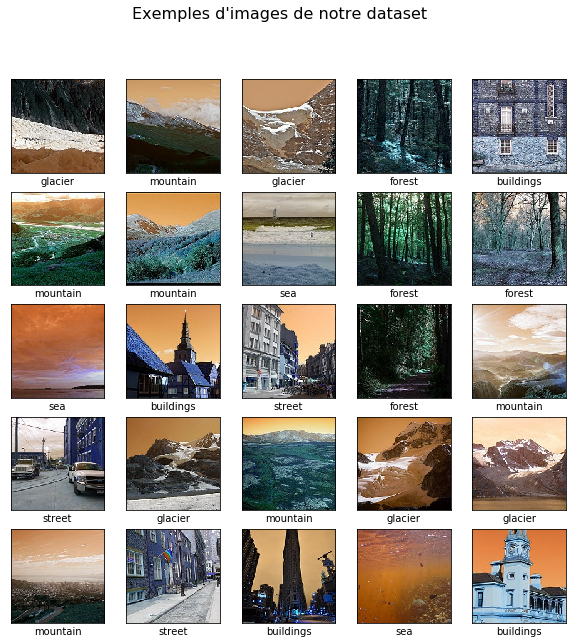

In [0]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Exemples d'images de notre dataset", fontsize=16)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_[y_train[i]])
plt.show()

# <a name="2">II. Apprentissage par rapport au 1000 premières images </a>

On récupère **les 1000 premières images**

In [0]:
X_train1 = X_train[:1000]
y_train1 = y_train[:1000]
X_test1 = X_test[:1000]
y_test1 = y_test[:1000]
#X_pred1=X_pred[:1000]
X_test_flatten = X_test1.reshape(X_test1.shape[0], -1)
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)
print(y_test1.shape)
#print(X_pred1.shape)

(1000, 150, 150, 3)
(1000,)
(1000, 150, 150, 3)
(1000,)


On applatit ensuite nos images

In [0]:
X_train_clf = X_train1.reshape(y_train1.shape[0],-1) 
X_test_clf = X_test1.reshape(X_test1.shape[0], -1)


### <a name="naives"> Naives Bayes Classifier </a>

Explication de la méthode :

Cette méthode est un algorithme d’apprentissage supervisé qui permet de classifier un ensemble d’observations selon des règles déterminées par l’algorithme lui-même. Cet outil de classification doit dans un premier temps être entraîné sur un jeu de données d’apprentissage qui montre la classe attendue en fonction des entrées. Pendant la phase d’apprentissage, l’algorithme élabore ses règles de classification sur ce jeu de donnée, pour les appliquer dans un second temps à la classification d’un jeu de données de prédiction. Le classificateur bayésien naïf implique que les classes du jeu de données d’apprentissage soit connu et fournit, d’où le caractère supervisé de l’outil.

Limite du modèle :

Le terme naïf désigne ici le fait que les descripteurs sont conditionnellement indépendants. Ce qui en pratique n’est presque jamais vrai. C’est une hypothèse forte et qui est violée dans la majorité des cas réels. Contre intuitivement, malgré la violation de la contrainte d’indépendance des variables, Naïve Bayes donne de bons résultats de classification.



Pour mettre en place un classifieur naïf de Bayes :

$\bullet$ On détermine un ensemble d’apprentissage

$\bullet$ On détermine des probabilités à priori de chaque classe (par exemple en observant les effectifs)

$\bullet$ On applique la règle de Bayes : $\mathbb{P}(Y=c|X=x)=\frac{\mathbb{P}(X=x|Y=c)\mathbb{P}(Y=c)}{\mathbb{P}(X=x)}$
pour obtenir la probabilité à posteriori des classes au point x

.

$\bullet$ On choisit la classe la plus probable.

Dans la formule de Bayes : $P(Y=c)$: La probabilité à priori

$P(X=x|Y=c)$: La probabilité conditionnelle d’appartenance à la classe $c$, qui peut être interprété comme la vraisemblance de cette classe.

La prédiction de la classification naïve bayésienne peut aboutir à un cas d’égalité où plusieurs classes obtiennent une même probabilité $P(Y)$

Deux approches sont proposées pour gérer ces cas :

$\bullet$ Choix aléatoire : choisi une classe de manière aléatoire dans l’ensemble des classes présentant la même probabilité $P(Y)$


$\bullet$ Plus petit indice : choisi la première classe rencontrée dans l’ensemble des classes présentant la même probabilité P(Y)


Le lissage de Laplace permet d’éviter d’obtenir des probabilités nulles ou égales à un (Le lissage peut aussi être vu comme une façon d’éviter le surentraînement d’un modèle sur un corpus, et de doter du modèle d’une plus grande capacité de généralisation).

Les distributions de probabilité utilisées sont indiquées.

Les variables qualitatives sont supposées suivre une distribution empirique.

La nature de la distribution a priori des classes (uniforme, non uniforme) est aussi rapportée.

Dans notre cas, nous avons choisi le Naive Bayes Classifier parce qu'il est rapide, probant et facile à utiliser.
La formation au modèle bilistique est simple et donne des résultats satisfaisants même si les données des tests est limitée.

In [0]:
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train_clf, y_train1)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
predictions = gnb_clf.predict(X_test_clf)
pred_labels = predictions

Affichage d'une image prédite et de sa véritable classe

In [0]:
index = np.random.randint(y_test.shape[0]) #choix aléatoire
print(index)
img_t = X_test[index].reshape(1,-1)
predictions = gnb_clf.predict(img_t)    
pred_img = np.argmax(predictions) 
pred_label = class_[predictions[pred_img]]
true_label = class_[y_test[index]] 
print(predictions)


1804
[5]


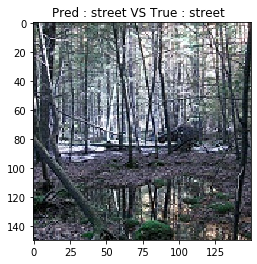

In [0]:
title = 'Pred : {} VS True : {}  '.format(pred_label , true_label )

plt.figure()
#plt.imshow(X_test[index])
plt.imshow(X_pred[index])
plt.grid(False)
plt.title(title)
plt.show()

Fonction qui renvoie 25 images qui n'ont pas été bien prédites par notre classifieur 

In [0]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
 
    TOF = (test_labels == pred_labels)
    mislabeled_indices = np.where(TOF == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Exemples d'images mal clasées:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_[mislabeled_labels[i]])
    plt.show()

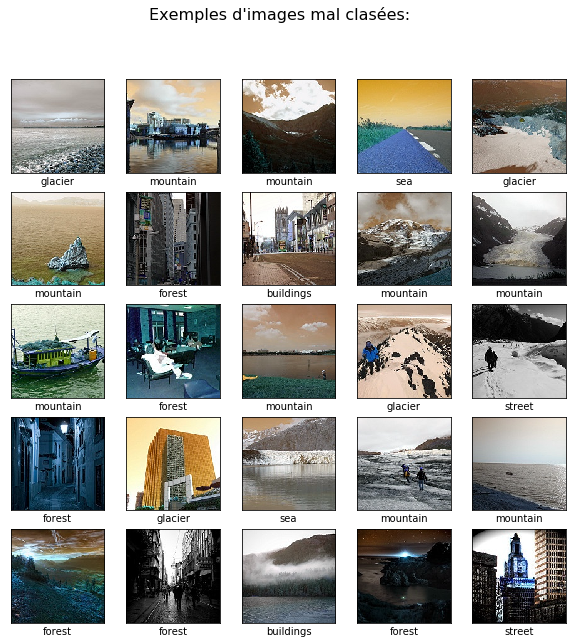

In [0]:

predictions = gnb_clf.predict(X_test_clf)
pred_labels = predictions ### nos prediction
print_mislabeled_images(class_, X_test1, y_test1, pred_labels)

In [0]:
gnb_clf.score(X_test_clf,y_test1)

0.458

In [0]:
gnb_clf.score(X_train_clf, y_train1)


0.52

---------------------------Rapport de Naives Bayes------------------------------


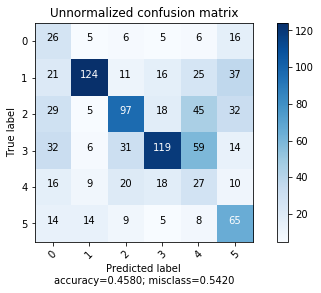

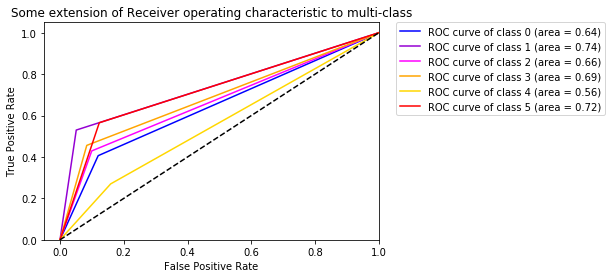

              precision    recall  f1-score   support

           0       0.41      0.19      0.26       138
           1       0.53      0.76      0.62       163
           2       0.43      0.56      0.49       174
           3       0.46      0.66      0.54       181
           4       0.27      0.16      0.20       170
           5       0.57      0.37      0.45       174

    accuracy                           0.46      1000
   macro avg       0.44      0.45      0.43      1000
weighted avg       0.44      0.46      0.43      1000



In [0]:
print("---------------------------Rapport de Naives Bayes------------------------------")
plt.figure(figsize=(7,7))
plt.subplot(212)
plot_confusion_matrix(y_test1,pred_labels)
Roc_Curve(y_test1,pred_labels)
print(metrics.classification_report(y_test1, pred_labels))

On obtient une précision de 45% sur nos donnée test. Nous voyons que la classe avec le meilleur score est celle de la foret 

### <a name="knn"> K plus proche voisin </a>

L’algorithme KNN figure parmi les plus simples algorithmes d’apprentissage artificiel. Dans un contexte de classification d’une nouvelle observation $X$, l’idée fondatrice simple est de faire voter les plus proches voisins de cette observation. La classe de $x$ est déterminée en fonction de la classe majoritaire parmi les k plus proches voisins de l’observation $x$. La méthode KNN est donc une méthode à base de voisinage, non-paramétrique. Ceci signifiant que l’algorithme permet de faire une classification sans faire d’hypothèse sur la fonction: 
$Y=f(X_1+X_2,.....,X_p)$

Elle relie la variable dépendante aux variables indépendantes.

KNN est une méthode non paramétrique où une nouvelle observation est classée dans la classe d’appartenance de l’observation de l’échantillon d’apprentissage qui lui est la plus proche, au regard des covariances utilisées. La détermination de leur similarité est basée sur des mesures de distance.

Soit $L$ l’ensemble de données à disposition ou échantillon d’apprentissage :$ L=\{(Y_i,X_i),i=1,....,n\}$

La détermination du plus proche voisin est basée sur une fonction distance arbitraire $( d(x,y))$ . La distance euclidienne ou dis-similarité entre deux individus caractérisés par p covariances est définie par:

$d(X,Y)=d((X_1,X_2,X_3....,X_p),(Y_1,Y_2,Y_3,....Y_p)) =\sqrt[]{(X_1-Y_1)^2+(X_2-Y_2)^2+.....(X_p-Y_p)^2}=\sqrt[]{\sum_{i=1}^n(X_i-Y_i)^2}=||X-Y||_2$

Bien sûr, nous pouvons également utiliser sa mesure de distance. Par exemple, la  distance Manhattan, défini comme: $d(X,Y)=|X_1-Y_1|+|X_2-Y_2|+|X_3+Y_3|+....+|X_n-Y_n|$

Aussi la distance de Minkowski, définie comme: $d(X,Y)=\sqrt[p]{(|X_1-Y_1|)^p+(|X_2-Y_2|)^p+....+(|X_n-Y_n|)^p}=\sqrt[p]{\sum_{i=1}^n(|X_i-Y_i|)^p}$

**Dans la méthode des $k$ plus proches voisins, la plus proche observation n’est plus la seule observation utilisée pour la classification. Nous utilisons désormais les $k$ plus proches observations. Ainsi la décision est en faveur de la classe majoritairement représentée par les $k$ voisins**. Soit $kr$ le nombre d’observations issues du groupe des plus proches voisins appartenant à la classe $r$: $\sum_{r=1}^cK_r=K$

Quelques règles sur le choix de k : Le paramètre k doit être déterminé par l’utilisateur : k appartient à N. En classification binaire, il est utile de choisir k impair pour éviter les votes égalitaires. Le meilleur choix de k dépend du jeu de donnée. En général, les grandes valeurs de k réduisent l’effet du bruit sur la classification et donc le risque de sur-apprentissage, mais rendent les frontières entre classes moins distinctes. Il convient donc de faire un choix de compromis entre la variabilité associée à une faible valeur de k contre un ‘oversmoothing’ ou sur-lissage (i.e gommage des détails) pour une forte valeur de k. Un bon k peut être sélectionné par diverses techniques heuristiques, par exemple, de validation-croisée. Nous choisirons la valeur de k qui minimise l’erreur de classification. Une grande base d’apprentissage permet une plus grande valeur de k. Nécessaire pour des petites bases d’apprentissage

In [0]:
from sklearn import neighbors

In [0]:
errors = []
for k in range(1,10):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train_clf, y_train1).score(X_test_clf, y_test1)))

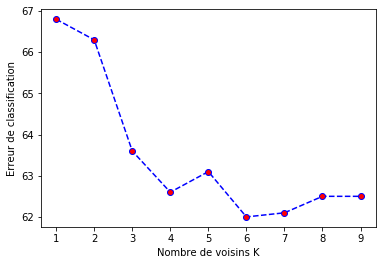

In [0]:
plt.plot(range(1,10), errors,color="blue",linestyle="dashed",marker='o',markerfacecolor="red")
plt.xlabel("Nombre de voisins K")
plt.ylabel("Erreur de classification")
plt.show()

Dans le graphe ci dessus il est difficile de savoir si l'erreur diminuera ou pas en fonction d'un nombre de voisin plus grand. Aussi la courbe augmente et diminue que ce soit avec un nombre pair ou impaire. Nous choisisons le k avec le meilleur score donc 6

In [0]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=6)
knn_clf.fit(X_train_clf, y_train1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [0]:
predictions = knn_clf.predict(X_test_clf)
pred_labels = predictions ### nos prediction
#print_mislabeled_images(class_, X_test1, y_test1, pred_labels)

---------------------------Rapport de KNN------------------------------


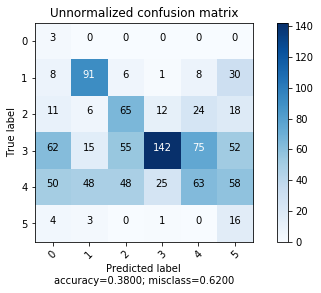

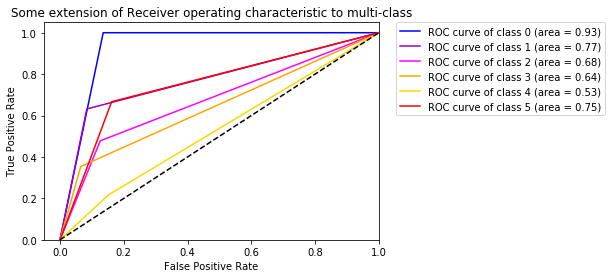

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       138
           1       0.63      0.56      0.59       163
           2       0.48      0.37      0.42       174
           3       0.35      0.78      0.49       181
           4       0.22      0.37      0.27       170
           5       0.67      0.09      0.16       174

    accuracy                           0.38      1000
   macro avg       0.56      0.37      0.33      1000
weighted avg       0.54      0.38      0.34      1000



In [0]:
print("---------------------------Rapport de KNN------------------------------")
plt.figure(figsize=(7,7))
plt.subplot(212)
plot_confusion_matrix(y_test1,pred_labels)
Roc_Curve(y_test1,pred_labels)
print(metrics.classification_report(y_test1, pred_labels))

### <a name="svm"> Machines à vecteurs de support </a>

Les SVM (Supports Vector Machine) ,machines à vecteurs de support sont une classe de modèles statistiques développés pour la première fois au milieu des années 60 par Vladimir Vapnik. Au cours des années suivantes, ce modèle a considérablement évolué pour devenir l'un des outils d'apprentissage machine les plus flexibles et les plus efficaces qui soient. Il s'agit d'un algorithme d'apprentissage supervisé qui peut être utilisé pour résoudre à la fois les problèmes de classification et de régression, même si l'accent est actuellement mis sur la classification uniquement.

Pour résumer, cet algorithme recherche un hyperplan séparable linéairement, ou une frontière de décision séparant les membres d'une classe de l'autre. Si un tel hyperplan existe, le travail est fait ! Si un tel hyperplan n'existe pas, le SVM utilise une cartographie non linéaire pour transformer les données d'entraînement dans une dimension supérieure. Ensuite, il recherche l'hyperplan de séparation optimal linéaire. Avec une cartographie non linéaire appropriée à une dimension suffisamment élevée, les données de deux classes peuvent toujours être séparées par un hyperplan. L'algorithme SVM trouve cet hyperplan en utilisant des vecteurs de support et des marges. En tant qu'algorithme d'apprentissage, le SVM n'est peut-être pas très rapide par rapport à d'autres méthodes de classification, mais grâce à sa capacité à modéliser des limites non linéaires complexes, le SVM a une grande précision.. Le SVM a été appliqué avec succès à la reconnaissance des chiffres manuscrits, à la classification des textes, à l'identification des locuteurs, etc.


Le Support Vector Machine (SVM) est un classificateur
discriminatoire utilisé pour la classification et l'analyse de
régression. Les exemples sont représentés sous forme de points
dans l'espace et un hyperplan de séparation est formellement
utilisé pour les définir et les classer en différentes catégories [9]. Il
est couramment utilisé pour effectuer une classification binaire
non probabiliste, mais nous pouvons étendre sa mise en œuvre
pour effectuer une classification multi-classes. Les MVC peuvent
non seulement effectuer une classification linéaire, mais aussi une
classification non linéaire en utilisant l'astuce du noyau où leurs
entrées sont mappées dans des espaces de caractéristiques à
haute dimension. Dans la figure 2, des points de données
bidimensionnels non linéaires séparables sont cartographiés dans  deux types de noyaux : Noyau de la fonction de base radiale
(RBF) et noyau polynomial puisqu'ils sont utilisés pour
l'hyperplan non linéaire. Finalement, nous avons choisi RBF
comme noyau parce qu'il a de meilleures performances sur les
données de test. Le noyau RBF est une fonction du noyau
couramment utilisée dans les machines vectorielles de support
qui cartographient les données d'entrée dans des espaces de
caractéristiques à haute dimension. Comme le montre
l'équation (1), le noyau RBF de notre MVC est le carré de la
distance euclidienne entre deux vecteurs caractéristiques :
K(x ; x0) = exp(
jjx x0jj2)
(1)
Ensuite, nous n'avons mis aucun paramètre réglons les paramètres kernel, gamma à scale et C du
MVC car ils ont un grand effet sur les performances du MVC
non linéaire. Le paramètre gamma définit la portée de
l'influence d'un seul exemple d'entraînement et le paramètre C
est un paramètre de régularisation et la pénalité pour les
données mal classées qui empêche le sur-ajustement. Enfin,
nous avons mis le gamma à "scale" et le C à 1,0 pour
optimiser notre modèle et en améliorer la précision.

In [0]:
from sklearn import svm

In [0]:
svm_clf = svm.SVC()
svm_clf.fit(X_train_clf, y_train1)



SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
predictions = svm_clf.predict(X_test_clf)
pred_labels = predictions
#print_mislabeled_images(class_, X_test1, y_test1, pred_labels)

In [0]:
svm_clf.score(X_train_clf, y_train1)choisison le

0.858

---------------------------Rapport de SVM------------------------------


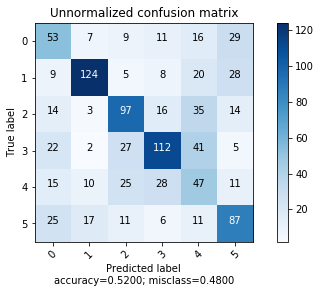

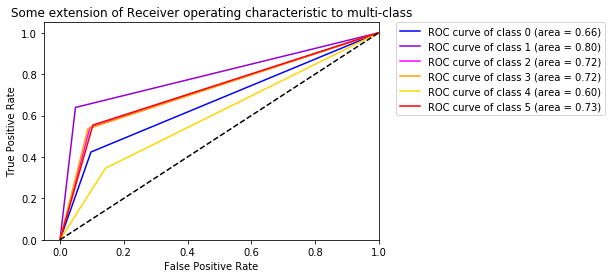

              precision    recall  f1-score   support

           0       0.42      0.38      0.40       138
           1       0.64      0.76      0.69       163
           2       0.54      0.56      0.55       174
           3       0.54      0.62      0.57       181
           4       0.35      0.28      0.31       170
           5       0.55      0.50      0.53       174

    accuracy                           0.52      1000
   macro avg       0.51      0.52      0.51      1000
weighted avg       0.51      0.52      0.51      1000



In [0]:
print("---------------------------Rapport de SVM------------------------------")
plt.figure(figsize=(7,7))
plt.subplot(212)
plot_confusion_matrix(y_test1,pred_labels)
Roc_Curve(y_test1,pred_labels)
print(metrics.classification_report(y_test1, pred_labels))

# <a name="3">III. Apprentissage sur l’ensemble des Images </a>

In [0]:
X_train_clf2 = X_train.reshape(y_train.shape[0],-1)
X_test_clf2 = X_test.reshape(y_test.shape[0],-1)

### <a name="rt"> Random Forest </a>

compose d'un certain nombre d'arbres, chaque arbre étant
cultivé selon une forme de randomisation. Les nœuds foliaires
de chaque arbre sont étiquetés par des estimations de la
distribution postérieure sur les classes d'images. Chaque
nœud interne contient un test qui divise au mieux l'espace des
données à classer. Une image est classée en l'envoyant à
chaque arbre et en agrégeant les distributions de feuilles
atteintes. Le caractère aléatoire peut être injecté à deux
moments de la formation : lors du sous-échantillonnage des
données de formation de manière à ce que chaque arbre soit
cultivé en utilisant un sous-ensemble différent ; et lors de la
sélection des tests de nœuds. [12]
Faire pousser les arbres. Les arbres ici sont binaires et
sont construits de manière descendante. Le test binaire à
chaque

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train_clf2, y_train)

NameError: ignored

In [0]:

import warnings
param_grid = {"n_estimators": [100,150],
              "n_jobs": [-1],
              "bootstrap": [True, False],
              "criterion": ["gini"]}
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier



In [0]:
X_train_rf = X_train.reshape(y_train.shape[0],-1)

In [0]:
X_test_flatten = X_test.reshape(y_test.shape[0],-1)

In [0]:


model=RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
best_model=grid_search.fit(X_test_clf2, y_test)
y_pred=best_model.predict(X_test_clf2)
print('Best Parameters:', best_model.best_estimator_.get_params()) 




Best Parameters: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [0]:
print('le meilleur score sur notre jeu de test est de : ',best_model.score(X_test_clf2, y_test))


le meilleur score sur notre jeu de test est de :  1.0


In [0]:
predictions = rf.predict(X_test_clf2)
pred_labels = predictions ### nos prediction

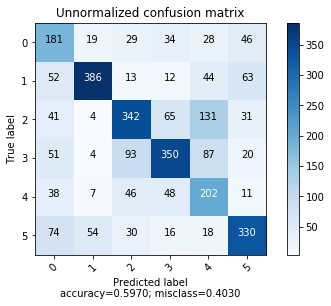

In [0]:
plot_confusion_matrix(y_test,pred_labels)

In [0]:
index = np.random.randint(X_test.shape[0]) 

img = X_test[index]
img_flatten = img.reshape(1,-1)
predictions = rf.predict(img_flatten)     
pred_img = np.argmax(predictions[0]) 
pred_label = class_[predictions[pred_img]]
true_label = class_[y_test[index]]

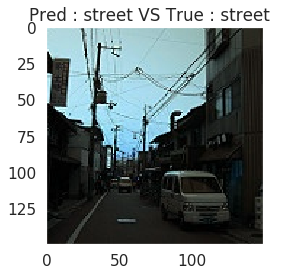

In [0]:
title = 'Pred : {} VS True : {}  '.format(pred_label , true_label )

plt.figure()
plt.imshow(X_test[index])
plt.grid(False)
plt.title(title)
plt.show()

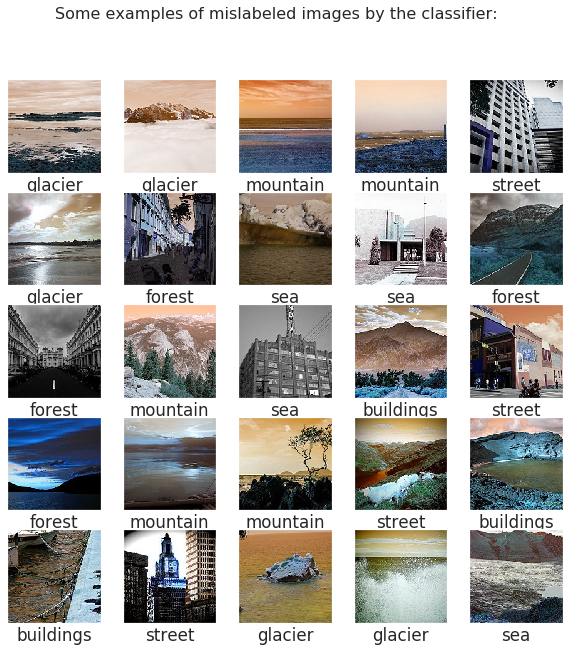

In [0]:
X_test_flatten = X_test.reshape(y_test.shape[0],-1)
predictions = rf.predict(X_test_flatten)
predictions1 = rf.predict(X_train.reshape(y_train.shape[0],-1))
pred_labels = predictions
print_mislabeled_images(class_, X_test, y_test, pred_labels)

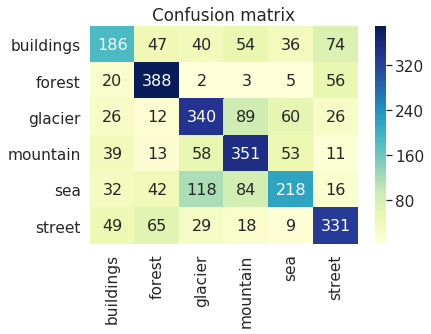

In [0]:
plot_confusion_matrix(y_test, pred_labels)

In [0]:
rf.score(X_test_flatten,y_test)

0.5986666666666667

In [0]:
rf.score(X_train.reshape(y_train.shape[0],-1),predictions1)

1.0

In [0]:
import tensorflow

In [0]:
# <a name="4">IV. Apprentissage sur  </a>

# ANN

In [0]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
X_test_flatten = X_test.reshape(X_test.shape[0], -1)
y_train_flatten = y_train.reshape(y_train.shape[0],-1)
y_test_flatten = y_test.reshape(y_test.shape[0],-1)


print(np.shape(X_train_flatten))
print(np.shape(X_test_flatten))
print(np.shape(y_train_flatten))
print(np.shape(y_test_flatten))

(14034, 67500)
(3000, 67500)
(14034, 1)
(3000, 1)


In [0]:

model = Models.Sequential()
model.add(Layers.Flatten(input_shape = (150,150,3))) # (14034, 150, 150) => (14034, 150*150)
model.add(Layers.Dense(128, activation='relu'))
model.add(Layers.Dropout(0.1))  
model.add(Layers.Dense(64, activation='relu'))
model.add(Layers.Dense(6, activation='softmax'))
model.compile(optimizer=Optimizer.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_split = 0.2 ) # 512 images each epoch
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



Train on 11227 samples, validate on 2807 samples
Epoch 1/50
11227/11227 [==============================] - 2s 182us/sample - loss: 12.4725 - acc: 0.1947 - val_loss: 2.8717 - val_acc: 0.2708
Epoch 2/50
11227/11227 [==============================] - 2s 162us/sample - loss: 2.5848 - acc: 0.2998 - val_loss: 1.5049 - val_acc: 0.4282
Epoch 3/50
11227/11227 [==============================] - 2s 161us/sample - loss: 1.5468 - acc: 0.3816 - val_loss: 1.4300 - val_acc: 0.4460
Epoch 4/50
11227/11227 [==============================] - 2s 160us/sample - loss: 1.4232 - acc: 0.4516 - val_loss: 1.3479 - val_acc: 0.4902
Epoch 5/50
11227/11227 [==============================] - 2s 160us/sample - loss: 1.3668 - acc: 0.4711 - val_loss: 1.3254 - val_acc: 0.4952
Epoch 6/50
11227/11227 [==============================] - 2s 161us/sample - loss: 1.3473 - acc: 0.4804 - val_loss: 1.3028 - val_acc: 0.5023
Epoch 7/50
11227/11227 [==============================] - 2s 160us/sample - loss: 1.3086 - acc: 0.4908 - val_l

In [0]:


scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
scores2 = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores2[1]*100))



14034/14034 [==============================] - 2s 166us/sample - loss: 1.1992 - acc: 0.5778

acc: 57.78%
3000/3000 [==============================] - 0s 162us/sample - loss: 1.3795 - acc: 0.4773

acc: 47.73%


In [0]:
print("Training set Accuracy: %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("Testing set Accuracy: %s: %.2f%%" % (model.metrics_names[1], scores2[1]*100))
print("Training set Error: %s: %.2f%%" % (model.metrics_names[1], 100-scores[1]*100))
print("Testing set Error: %s: %.2f%%" % (model.metrics_names[1], 100-scores2[1]*100))

Training set Accuracy: acc: 57.78%
Testing set Accuracy: acc: 47.73%
Training set Error: acc: 42.22%
Testing set Error: acc: 52.27%


In [0]:
train_error = 1-np.asarray(history.history['acc'])
val_error = 1-np.asarray(history.history['val_acc'])

<Figure size 504x360 with 0 Axes>

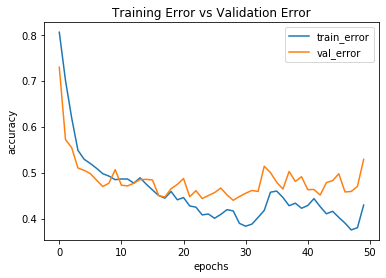

In [0]:
fig = plt.figure(figsize=(7,5))
plt.figure(facecolor='white')
plt.plot(train_error,label = "train_error")
plt.plot(val_error,  label = "val_error")
plt.title("Training Error vs Validation Error")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(loc='best')

plt.show()

<Figure size 504x360 with 0 Axes>

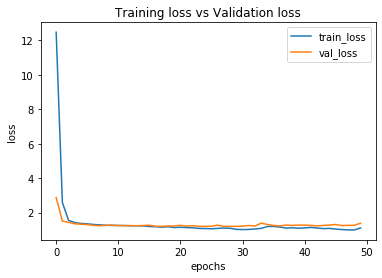

In [0]:
fig = plt.figure(figsize=(7,5))
plt.figure(facecolor='white')
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.title("Training loss vs Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()



In [0]:


num =64;
model2 = Models.Sequential()
model2.add(Layers.Flatten(input_shape = (150,150,3))) # (14034, 150, 150) => (14034, 150*150)
model2.add(Layers.Dense(128, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(num, activation='relu'))
model2.add(Layers.Dense(6, activation='softmax'))
model2.compile(optimizer=Optimizer.Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['acc'])
# history3 = model3.fit(train_images, train_labels, epochs=5, batch_size=512,validation_split = 0.2, verbose=0) # 每批512张图片
history2 = model2.fit(X_train, y_train, epochs=50, batch_size=512, validation_split = 0.2 ) 
scores = model2.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))



Train on 11227 samples, validate on 2807 samples
Epoch 1/50
11227/11227 [==============================] - 2s 220us/sample - loss: 1.7678 - acc: 0.1966 - val_loss: 1.7093 - val_acc: 0.2768
Epoch 2/50
11227/11227 [==============================] - 2s 191us/sample - loss: 1.6464 - acc: 0.3078 - val_loss: 1.5899 - val_acc: 0.2950
Epoch 3/50
11227/11227 [==============================] - 2s 190us/sample - loss: 1.4967 - acc: 0.3535 - val_loss: 1.6119 - val_acc: 0.3060
Epoch 4/50
11227/11227 [==============================] - 2s 189us/sample - loss: 1.4492 - acc: 0.3733 - val_loss: 1.4304 - val_acc: 0.3755
Epoch 5/50
11227/11227 [==============================] - 2s 195us/sample - loss: 1.4125 - acc: 0.3939 - val_loss: 1.4721 - val_acc: 0.3823
Epoch 6/50
11227/11227 [==============================] - 2s 190us/sample - loss: 1.3856 - acc: 0.4057 - val_loss: 1.3907 - val_acc: 0.4211
Epoch 7/50
11227/11227 [==============================] - 2s 190us/sample - loss: 1.3590 - acc: 0.4262 - val_lo

In [0]:
train_error2 = 1-np.asarray(history2.history['acc'])
val_error2 = 1-np.asarray(history2.history['val_acc'])

In [0]:
fig = plt.figure(figsize=(7,5))
plt.figure(facecolor='white')
plt.plot(train_error2,label = "train_error")
plt.plot(val_error2,  label = "val_error")
plt.title("Training Error vs Validation Error")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(loc='best')

plt.show()

NameError: ignored

<Figure size 504x360 with 0 Axes>

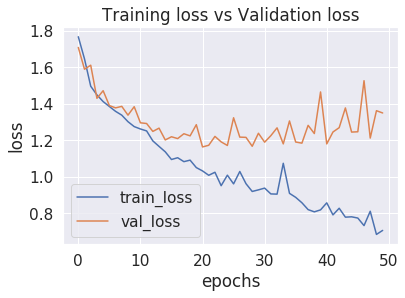

In [0]:
fig = plt.figure(figsize=(7,5))
plt.figure(facecolor='white')
plt.plot(history2.history['loss'], label = "train_loss")
plt.plot(history2.history['val_loss'], label = "val_loss")
plt.title("Training loss vs Validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()



In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14034, 150, 150, 3)
(14034,)
(3000, 150, 150, 3)
(3000,)


# <a name="4">IV. Apprentissage sur  </a>

## CNN

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D

Using TensorFlow backend.


In [0]:
seg_train = "/tmp/seg_train/seg_train/"
seg_test = "/tmp/seg_test/seg_test/"

In [117]:
generate = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = generate.flow_from_directory(seg_train,
                                            target_size = (100, 100), #On change la dimension en 100*100
                                            batch_size = 14034,
                                            classes = class_,
                                            class_mode = 'categorical')
test_set = generate.flow_from_directory(seg_test,
                                        target_size = (100, 100),
                                        batch_size = 3000,
                                        classes = class_,
                                        class_mode = 'categorical')






Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
X_train,y_train = training_set.next()
X_test,y_test = test_set.next()

In [0]:
type(X_train)
X_train.shape

(14034, 100, 100, 3)

In [0]:
import tensorflow

In [0]:
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers 
import tensorflow.keras.activations as Activations
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from tensorflow.keras.models import Sequential

In [0]:
with tensorflow.device("/gpu:0"):
  model = Sequential()
  model.add(Layers.Conv2D(32,(3,3), input_shape=(100,100,3), activation='relu'))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=None))
  model.add(Layers.Conv2D(64,(3,3), activation='relu' , padding= "same"))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=None))
  model.add(Layers.Conv2D(64,(3,3), activation='relu' , padding= "same"))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=None))
  model.add(Layers.Conv2D(128,(3,3), activation='relu' , padding= "same"))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=None))
  model.add(Layers.Conv2D(128,(3,3), activation='relu' , padding= "same"))
  model.add(Layers.MaxPool2D(pool_size=(2,2),strides=None))
  model.add(Layers.Flatten()) 
  model.add(Layers.Dense(512, activation='relu'))
  model.add(Layers.Dropout(0.50))
  model.add(Layers.Dense(6,activation ='softmax'))
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
  model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)      

In [0]:
Model = model.fit(X_train, y_train, epochs = 15, batch_size=500, verbose=1, validation_split= 0.1)

Train on 12630 samples, validate on 1404 samples
Epoch 1/15
12630/12630 [==============================] - 3s 231us/sample - loss: 1.4924 - acc: 0.3815 - val_loss: 1.2323 - val_acc: 0.5100
Epoch 2/15
12630/12630 [==============================] - 3s 212us/sample - loss: 1.0578 - acc: 0.5863 - val_loss: 1.0030 - val_acc: 0.5919
Epoch 3/15
12630/12630 [==============================] - 3s 212us/sample - loss: 0.9460 - acc: 0.6327 - val_loss: 0.9318 - val_acc: 0.6346
Epoch 4/15
12630/12630 [==============================] - 3s 213us/sample - loss: 0.8521 - acc: 0.6742 - val_loss: 0.8566 - val_acc: 0.6766
Epoch 5/15
12630/12630 [==============================] - 3s 212us/sample - loss: 0.8022 - acc: 0.6982 - val_loss: 0.7912 - val_acc: 0.6895
Epoch 6/15
12630/12630 [==============================] - 3s 213us/sample - loss: 0.7397 - acc: 0.7221 - val_loss: 0.8125 - val_acc: 0.7123
Epoch 7/15
12630/12630 [==============================] - 3s 212us/sample - loss: 0.7003 - acc: 0.7431 - val_lo

In [0]:
score = model.evaluate(X_train, y_train, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14034/14034 [==============================] - 2s 159us/sample - loss: 0.3690 - acc: 0.8740
Test loss: 0.36898835599464924
Test accuracy: 0.8740202


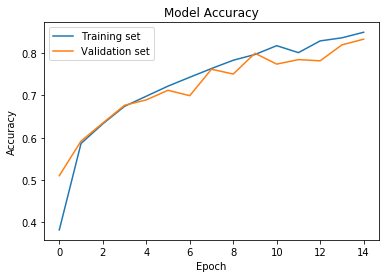

In [0]:
plt.plot(Model.history['acc'])
plt.plot(Model.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()



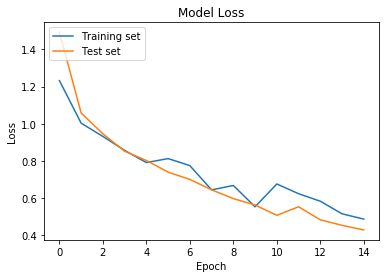

In [0]:
plt.plot(Model.history['val_loss'])
plt.plot(Model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [0]:
model.save("model.h5")

In [0]:
import matplotlib.gridspec as gridspec

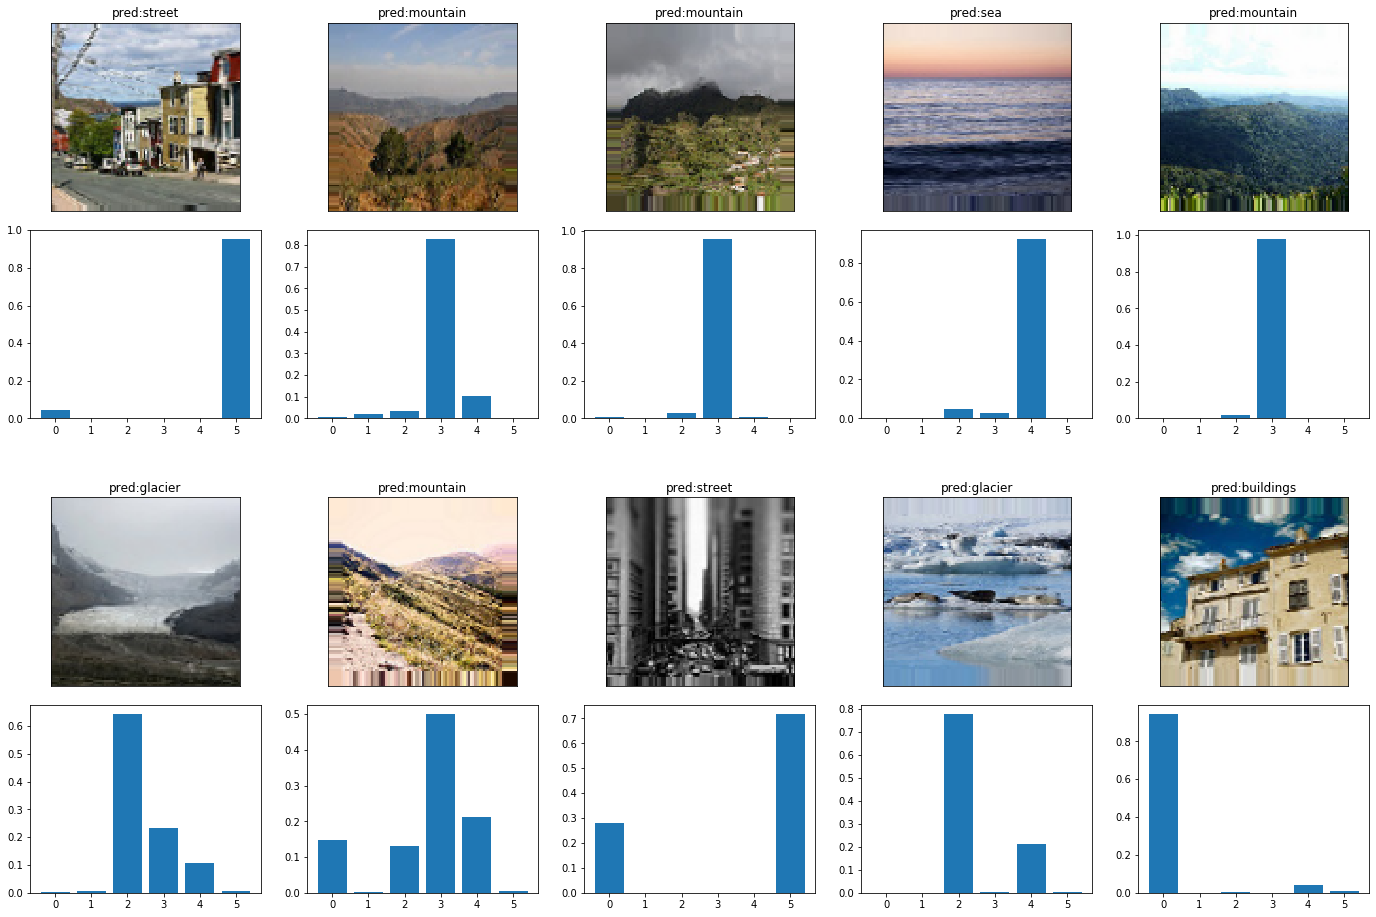

In [0]:
fig = plt.figure(figsize=(24, 16))
outer = gridspec.GridSpec(2, 5, wspace=0.2, hspace=0.2)

for i in range(10):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(X_test))
    X_test1 = np.array([X_test[rnd_number]])
    pre_labels = model.predict(X_test1)
    pred_prob = pre_labels.reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(X_test1[0])
            ax.set_title('pred:{}'.format(get_classlabel(int(np.argmax(pre_labels, axis = 1)))))
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

In [0]:
pre_labels = model.predict(X_test)

In [0]:
pre_labels = np.argmax(pre_labels, axis = 1)

In [0]:
pre_labels

array([4, 4, 4, ..., 4, 4, 4])

In [0]:
y_test
y_test= list(y_test)
y_test1
L=[]

for i in y_test1: 
  L.append(list(i).index(1.))

Y_test=np.array(L) # de facon a avoir les labels en entier 

In [139]:
pre_labels
G=[]
for i in pre_labels: 
  G.append(np.argmax(i))
Pred_labels=np.array(G)
Pred_labels  # de facon à avoir les labels en entier 

array([2, 5, 1, ..., 3, 3, 4])

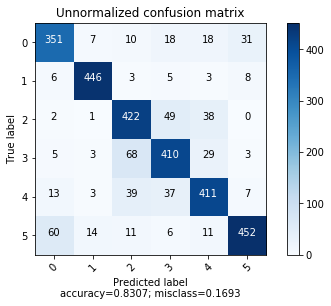

In [140]:
plot_confusion_matrix(Y_test, Pred_labels)